### A hands-on testing of *CNTK_101* 
https://github.com/Microsoft/CNTK/blob/v2.0.beta3.0/bindings/python/tutorials/CNTK_102_FeedForward.ipynb

In [62]:
from cntk import blocks
import cntk.ops as C
from cntk.layers import Dense
from cntk.models import Sequential
from cntk.learner import sgd
from cntk.trainer import Trainer
import numpy as np
import matplotlib.pyplot as plt

In [90]:
from cntk.utils import get_train_eval_criterion, get_train_loss
def moving_average(a, w=10) :
    
    if len(a) < w: 
        return a[:]    #Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

def print_loss_eval(trainer, ii, freq, verbose=0):
    previous_minibatch_loss = 'Na'
    previous_minibatch_eval = 'Na'
    if ii % freq == 0:
        previous_minibatch_loss = get_train_loss(trainer)
        previous_minibatch_eval = get_train_eval_criterion(trainer)
        if verbose:
            print ('loss: {0}, eval: {1}'.format(previous_minibatch_loss, previous_minibatch_eval))
    return ii, previous_minibatch_loss, previous_minibatch_eval

In [72]:
#Ensure we always get the same amount of randomness
np.random.seed(0)

# Define the data dimensions
input_dim = 2
num_output_classes = 2
#Helper function to generate a random data sample
def generate_random_data_sample(sample_size, feature_dim, num_classes):
    # Create synthetic data using NumPy. 
    Y = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)

    # Make sure that the data is separable
    X = (np.random.randn(sample_size, feature_dim)+3) * (Y+1)
    X = X.astype(np.float32)    
    # converting class 0 into the vector "1 0 0", 
    # class 1 into vector "0 1 0", ...
    class_ind = [Y==class_number for class_number in range(num_classes)]
    Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    return X, Y   

In [73]:
# Create the input variables denoting the features and the label data. Note: the input_variable 
# does not need additional info on number of observations (Samples) since CNTK first create only 
# the network tooplogy first 
mysamplesize = 64
features, labels = generate_random_data_sample(mysamplesize, input_dim, num_output_classes)


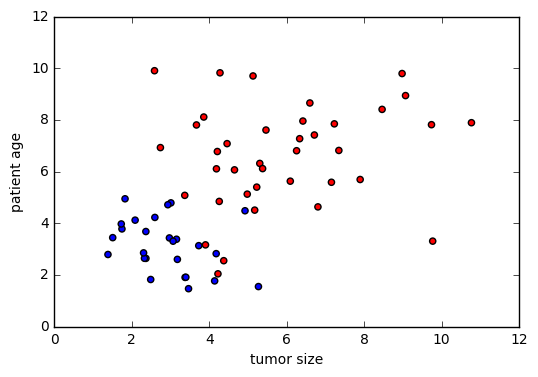

In [74]:
colors = ['r' if l==0 else 'b' for l in labels[:, 0]]
plt.scatter(features[:, 0], features[:, 1], c=colors)
plt.xlabel('tumor size')
plt.ylabel('patient age')
plt.show()

In [118]:
input = C.input_variable(input_dim)
label = C.input_variable(num_output_classes)
hidden_layers_dim = 100

In [128]:
mlp = Sequential([Dense(hidden_layers_dim, activation=C.sigmoid),
                 Dense(num_output_classes)])(input)

In [129]:
learner = sgd(mlp.parameters, lr=0.01)
loss_fn = C.cross_entropy_with_softmax(mlp, label)
eval_fn = C.classification_error(mlp, label)
trainer = Trainer(mlp, loss_fn, eval_fn, [learner])

In [130]:
num_samples = 20000
minibatch_size = 25
num_minibatches = num_samples/minibatch_size
plot_data = {'num_mb':[], 'loss':[], 'eval':[]}
for ii in range(0, int(num_minibatches)):
    mb_feat, mb_label = generate_random_data_sample(minibatch_size, input_dim, num_output_classes)
    trainer.train_minibatch({input: mb_feat, label:mb_label})
    num_mb, loss, eval = print_loss_eval(trainer, ii, 10)
    if (loss != 'Na' and eval != 'Na'):
        plot_data['num_mb'].append(num_mb)
        plot_data['loss'].append(loss)
        plot_data['eval'].append(eval)
    #previous_minibatch_loss = get_train_loss(trainer)

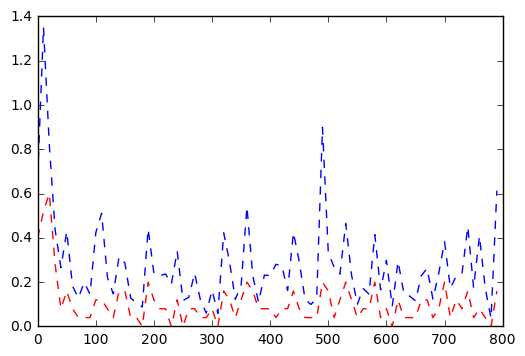

In [131]:
#plot_data['loss'] = moving_average(plot_data['loss'])
#plot_data['eval'] = moving_average(plot_data['eval'])
plt.plot(plot_data['num_mb'], plot_data['loss'], '--')
plt.plot(plot_data['num_mb'], plot_data['eval'], '--', c='r')
plt.show()